In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatMessagePromptTemplate


load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = os.getenv('LANGCHAIN_TRACING_V2')
os.environ["LANGCHAIN_PROJECT"] = os.getenv('LANGCHAIN_PROJECT')
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')

In [2]:
# helper fuction
import base64

def load_image(image_path: str) -> str:
    """Load image from file and encode it as base64."""
    def encode_image(image_path):
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    image_base64 = encode_image(image_path)
    return image_base64

image_url = "pagila-schema-diagram.png"
image_data = load_image(image_url)

In [3]:
from typing import Annotated, Sequence, TypedDict,List, Dict, Any, Optional

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


In [30]:
from pydantic import BaseModel, Field
from typing import List, Dict, Any, Optional

def get_related_table_details(state):
    """
    This function takes in the state and image data and returns the related table details.
    """
    # Get the related table details
    
    query = state["messages"][-1].content
    class QueryParse(BaseModel):
        is_relevant: bool = Field(description="Is the query relevant to the database")
        relevant_tables_and_columns: Optional[dict] = Field(description="Relevant tables and columns, including foreign keys and primary keys details.")
    
    model = ChatOpenAI(model="gpt-4o", temperature=0).with_structured_output(QueryParse)

    prompt = [
        SystemMessage(content="""
            You are a highly skilled data analyst with expertise in analyzing SQL databases and understanding their structure. 
            You are provided with an ER diagram (ERD) for a PostgreSQL database and a natural language user query referred to as `query`.

            Your task is as follows:
            1. Use the ER diagram to carefully examine the structure of the PostgreSQL database, including tables, columns, relationships, foreign keys, and primary keys.
            2. Identify and list all relevant tables and columns that could be used to answer the user's query. This includes analyzing relationships between tables, such as foreign key constraints and how different tables connect to one another.
            3. **Do not generate any SQL queries.** Your job is to strictly identify and return only the relevant tables and columns, which will assist in creating the SQL query later.
            4. If the query does not align with the structure of the database or if there is insufficient information, mark `is_relevant` as `false`. Otherwise, set `is_relevant` to `true` and provide a detailed list of relevant tables and columns in JSON format, including primary and foreign key details.

            Make sure the response is concise and structured correctly, without any unnecessary details or explanations.
        """),
        HumanMessage(
            content=[
                {"type": "text", "text": f"query: {query}"},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
                },
            ],
        )
    ]

    response = model.invoke(prompt)
    state["ERD_info"] = response
    return state


In [39]:
from langchain_core.prompts import ChatPromptTemplate

def generate_sql_query(state):
    prompt = ChatPromptTemplate(
        [
            ("system", """
                You are an expert SQL query generator with deep knowledge of PostgreSQL syntax and best practices. 
                You are given a PostgreSQL database schema which contains relevant tables and columns, referred to as `relevant_tables_and_columns`. 
                Additionally, you will receive a natural language user query, referred to as `query`, that needs to be transformed into a valid, efficient, 
                and correct PostgreSQL SQL query. 

                Your task is to:
                1. Analyze the given `relevant_tables_and_columns` structure to identify the appropriate tables and columns needed for the query.
                2. Interpret the user's query and map it to the correct SQL operations (e.g., SELECT, JOIN, WHERE, GROUP BY, etc.).
                3. Ensure that the SQL query is optimized, adheres to PostgreSQL standards, and accurately represents the intent of the user's query.
                4. Handle edge cases such as ambiguous column names, missing conditions, or complex queries by making reasonable assumptions or asking for clarification when needed.

                Your response should consist solely of the generated SQL query in correct syntax, without any additional explanation.
            """),
            ("human", """
                relevant_tables_and_columns: {relevant_tables_and_columns}
                query: {query}
            """)
        ]
    )
    llm = ChatOpenAI(model="gpt-4o", temperature=0)
    chain = prompt | llm 
    response = chain.invoke({
        "relevant_tables_and_columns": state["ERD_info"].relevant_tables_and_columns, 
        "query": state["messages"][0].content
    })
    print(response)
    return {"messages": [response]}

In [40]:
import psycopg2

@tool
def fatch_data_from_db(query: str) -> list:
    """Fetches data from a PostgreSQL database using the provided SQL query.
    This tool connects to a PostgreSQL database and executes the provided SQL query. 
    It retrieves all the resulting data and returns it as a list of tuples. Each tuple represents a row of data fetched from the database."""
    conn = psycopg2.connect(database="postgres",
                        host="localhost",
                        user="postgres",
                        password="123456",
                        port="5432")
    cursor = conn.cursor()
    cursor.execute(query)
    result = cursor.fetchall()
    return result

In [41]:
def agent_with_tools(state):
    llm = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools([fatch_data_from_db])
    messages = state["messages"][-1].content
    response = llm.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


In [42]:
def html_generater(state):
    llm = ChatOpenAI(model="gpt-4o", temperature=0, model_kwargs={"response_format": { "type": "json_object" }})
    messages = state["messages"][-1].content
    query = state["messages"][0].content

    prompt2 = [
        SystemMessage(content="""
            You are a skilled data formatter and visualization expert. 
            Given a PostgreSQL SQL query and the resulting data from the query, your task is to transform the output into a visually appealing HTML format.
            
            Here’s what you need to do:
            1. **Analyze the result data**: Review the structure of the result and determine the best way to present it, whether in a table, bar chart, line chart, or pie chart.
            2. **Charts**: You may use only 'bar', 'line', or 'pie' charts for visualizing the data. Choose a chart type based on the data distribution and what best represents the information.
               - Provide the chart details in the following format:
                 ```json
                 {
                     'format': 'chart',
                      'chart_type': '<A suitable chart format.',
                     'chart_title': '<A suitable title for the chart>',
                     'labels': <list of labels>,
                     'data': <list of corresponding data points>
                 }
                 ```
               - Example: 
                 ```json
                 {
                     'format': 'chart',
                      'chart_type': 'bar',
                     'chart_title': 'Monthly Sales Data',
                     'labels': ['January', 'February', 'March'],
                     'data': [500, 600, 550]
                 }
                 ```
            3. **Tables**: If a chart is not suitable for the data, present it in table format:
               - Provide the table details in this format:
                 ```json
                 {
                     'format': 'table',
                     'headers': <list of column headers>,
                     'rows': <list of rows with corresponding data>
                 }
                 ```
               - Example:
                 ```json
                 {
                     'format': 'table',
                     'headers': ['Name', 'Age', 'City'],
                     'rows': [
                         ['John', 28, 'New York'],
                         ['Jane', 22, 'Los Angeles'],
                         ['Doe', 35, 'Chicago']
                     ]
                 }
                 ```
            4. **No Visual Needed**: If the data doesn't require a chart or table (e.g., simple text), respond with a plain message in the following format:
               ```json
               {
                   'format': 'message',
                   'content': 'Provide the text message here'
               }
               ```
            Your goal is to select the most appropriate visual (chart, table, or message) based on the query results and format the response as structured JSON.
        """),
        HumanMessage(content=f"""query: {query}, result: {messages}""")
    ]

    response = llm.invoke(prompt2)
    # print(response.content)
    return {"messages": [response]}


In [94]:
from typing import Annotated, Literal, Sequence, TypedDict
from langgraph.graph import END, StateGraph, START

def sanitize_sql_query_with_llm(state) -> Literal[ END , "agent_with_tools"]:
    """
    This function uses OpenAI's LLM to sanitize a given SQL query, allowing only 'SELECT' operations.
    Any query that contains 'UPDATE', 'INSERT', 'DELETE', or other modifying operations will be flagged as unsafe.

    Parameters:
    query (str): The SQL query to be sanitized.

    Returns:
    bool: True if the query is valid (SELECT-only), False otherwise.
    """
    class sanitizing_queries(BaseModel):
        is_safe: bool
        reason: str
    
    query = state["messages"][-1].content

    llm = ChatOpenAI(model="gpt-4o", temperature=0).with_structured_output(sanitizing_queries)
    
    # Define the system prompt to instruct the model to analyze the SQL query for safety
    prompt = [
        SystemMessage(content="""
            You are an expert in SQL security. Your task is to analyze a given SQL query and determine whether it is a safe read-only query. 
            Only queries that retrieve data (i.e., SELECT queries) are allowed. 
            If the query contains any modifying operations like INSERT, UPDATE, DELETE, DROP, ALTER, or TRUNCATE, mark it as unsafe.
            Your response should be in the following format:
            
            {
                "is_safe": true/false,
                "reason": "<Explain why the query is safe or unsafe>"
            }
        """),
        HumanMessage(content=f"""SQL query: {query}""")
    ]
    
    # Invoke the model with the provided query
    response = llm.invoke(prompt)
    
    if response.is_safe == True:
        return "agent_with_tools"
    else:
        globals()['error_message'] = {
                "format": "message",
                "content": response.reason
            }
        
    
        return END

In [95]:
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]
    ERD_info : BaseModel
    

def check_query_relavency(state :AgentState) -> Literal[ END , "generate_sql_query"]:
    messgae = state["ERD_info"]
    if messgae.is_relevant == True:
        return "generate_sql_query"
    else:
        globals()['error_message'] = {
            "format": "message",
            "content": "The query is not relevant to this table."
        }
        return END



# Define a new graph
workflow = StateGraph(AgentState)

#workflow.add_node("get_related_table_deatils", get_related_table_deatils)
# Define the nodes we will cycle between
workflow.add_node("get_related_table_details", get_related_table_details)
# Define the nodes we will cycle between
workflow.add_node("generate_sql_query", generate_sql_query)
workflow.add_node("agent_with_tools", agent_with_tools)
workflow.add_node("html_data_generater", html_generater)
#workflow.add_node("sanitize_sql_query", sanitize_sql_query_with_llm)
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "get_related_table_details")
#workflow.add_node("grade_documents", grade_documents)
sql_tool = ToolNode([fatch_data_from_db])
workflow.add_node("sql_tool", sql_tool)

## adding the condition edges
workflow.add_conditional_edges(
    "get_related_table_details",
    # Assess agent decision
    check_query_relavency,
)

# Decide whether to contiue
workflow.add_conditional_edges(
    "agent_with_tools",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "sql_tool",
        END: END,
    },
)

workflow.add_conditional_edges(
    "generate_sql_query",
    #
    sanitize_sql_query_with_llm

)

#workflow.add_edge("rewrite","agent_with_tools")
workflow.add_edge("sql_tool", "html_data_generater")
workflow.add_edge("html_data_generater", END)
# Compile
graph = workflow.compile()

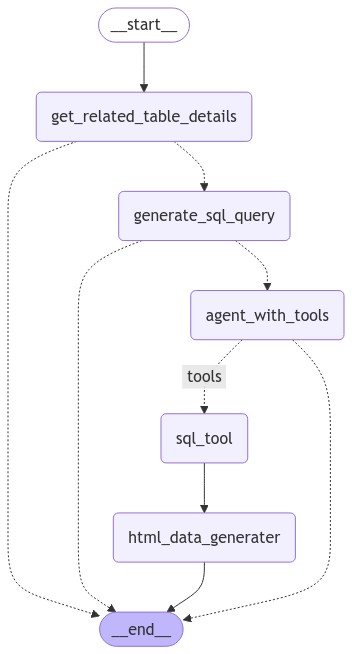

In [96]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [108]:
import pprint

inputs = {
    "messages": [
        ("user", "List all actors' first and last names."),
    ]
}

#globals().pop('error_message')

graph.invoke(inputs)

content='```sql\nSELECT first_name, last_name\nFROM actor;\n```' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 284, 'total_tokens': 298, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_992d1ea92d', 'finish_reason': 'stop', 'logprobs': None} id='run-bb4982b0-8305-475c-81a5-8baad8a1d296-0' usage_metadata={'input_tokens': 284, 'output_tokens': 14, 'total_tokens': 298}


{'messages': [HumanMessage(content="List all actors' first and last names.", additional_kwargs={}, response_metadata={}, id='fb6e31e0-f326-4a07-ac39-75d80ee10138'),
  AIMessage(content='```sql\nSELECT first_name, last_name\nFROM actor;\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 284, 'total_tokens': 298, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_992d1ea92d', 'finish_reason': 'stop', 'logprobs': None}, id='run-bb4982b0-8305-475c-81a5-8baad8a1d296-0', usage_metadata={'input_tokens': 284, 'output_tokens': 14, 'total_tokens': 298}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_woLho3Ut4molNQ0vD8oJpf64', 'function': {'arguments': '{"query":"SELECT first_name, last_name FROM actor;"}', 'name': 'fatch_data_from_db'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'pr

In [109]:
type(globals()['error_message'])

KeyError: 'error_message'

In [104]:
globals()['error_message']

{'format': 'message',
 'content': 'The query contains an INSERT operation, which modifies the database. Only SELECT queries are allowed for read-only access.'}